In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pathlib import Path

In [2]:
PROC = Path("../data/processed/MSFT_clean.csv")
df = pd.read_csv(PROC, parse_dates=["Date"], usecols=['Date','Close','High','Low','Open','Volume'])

In [3]:
df

,Date,Close,High,Low,Open,Volume
0,2017-12-26,78.691513,78.811299,78.350575,78.608579,9891200
1,2017-12-27,78.977196,79.225990,78.525689,78.921911,14678000
2,2017-12-28,78.986404,79.179907,78.829760,79.152265,10594300
3,2017-12-29,78.820526,79.290466,78.783667,78.903453,18717400
4,2018-01-02,79.198318,79.530040,78.783670,79.364179,22483800
...,...,...,...,...,...,...
1956,2025-10-08,524.849976,526.950012,523.090027,523.280029,13363400
1957,2025-10-09,522.400024,524.330017,517.400024,522.340027,18343600
1958,2025-10-10,510.959991,523.580017,509.630005,519.640015,24133800
1959,2025-10-13,514.049988,516.409973,511.679993,516.409973,14284200


In [4]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

In [5]:
df['DayOfWeek'] = df['Date'].dt.dayofweek

In [6]:
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

In [7]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

In [8]:
# Average True Range (ATR) - a popular volatility indicator
df['High-Low'] = df['High'] - df['Low']
df['High-Prev_Close'] = np.abs(df['High'] - df['Close'].shift(1))
df['Low-Prev_Close'] = np.abs(df['Low'] - df['Close'].shift(1))
df['TR'] = df[['High-Low', 'High-Prev_Close', 'Low-Prev_Close']].max(axis=1)
df['ATR'] = df['TR'].rolling(window=14).mean()
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter
df['DayOfYear'] = df['Date'].dt.dayofyear

In [9]:
# Create Lag Features for recent days
for i in range(1, 6):  # Create lags for the past 5 days
    df[f'Close_lag_{i}'] = df['Close'].shift(i)
    df[f'Volume_lag_{i}'] = df['Volume'].shift(i)
    df[f'ATR_lag_{i}'] = df['ATR'].shift(i)


In [10]:
# --- Multi-output target creation ---
HORIZON = 30  # Number of days to forecast
for i in range(1, HORIZON + 1):
    df[f"target_t+{i}"] = df['Close'].shift(-i)

In [11]:
df = df.dropna().reset_index(drop=True)
train_df = df.iloc[:-30].copy()
test_df  = df.iloc[-30:].copy()

target_cols = [f"target_t+{i}" for i in range(1, HORIZON + 1)]

In [12]:
df

,Date,Close,High,Low,Open,Volume,EMA_9,SMA_5,SMA_10,SMA_15,...,target_t+21,target_t+22,target_t+23,target_t+24,target_t+25,target_t+26,target_t+27,target_t+28,target_t+29,target_t+30
0,2018-02-13,82.773567,82.930211,80.903031,81.944264,26407700,83.042324,81.688087,83.395527,84.102275,...,87.189491,87.578308,85.995232,86.217422,85.615669,83.125351,80.709053,86.819183,82.829094,82.755028
1,2018-02-14,84.069633,84.236273,81.847779,81.940355,34960900,83.014679,81.411656,83.127390,83.975116,...,87.578308,85.995232,86.217422,85.615669,83.125351,80.709053,86.819183,82.829094,82.755028,84.495499
2,2018-02-15,85.782310,85.837855,83.893729,84.439933,27823900,83.122883,81.711420,82.779689,83.939277,...,85.995232,86.217422,85.615669,83.125351,80.709053,86.819183,82.829094,82.755028,84.495499,81.949600
3,2018-02-16,85.171295,86.559958,84.986143,85.587891,30596900,83.394955,83.201447,82.672363,83.986286,...,86.217422,85.615669,83.125351,80.709053,86.819183,82.829094,82.755028,84.495499,81.949600,83.051270
4,2018-02-20,85.837852,86.152613,84.254778,84.689894,30911700,83.576266,83.985071,82.732456,83.886289,...,85.615669,83.125351,80.709053,86.819183,82.829094,82.755028,84.495499,81.949600,83.051270,85.476822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1893,2025-08-26,502.040009,504.980011,498.510010,504.359985,30835700,512.879876,505.910675,513.484048,516.525665,...,507.029999,511.459991,514.599976,517.950012,519.710022,515.739990,517.349976,528.570007,523.979980,524.849976
1894,2025-08-27,506.739990,507.290009,499.899994,502.000000,17277900,511.795889,504.532007,510.850909,514.869409,...,511.459991,514.599976,517.950012,519.710022,515.739990,517.349976,528.570007,523.979980,524.849976,522.400024
1895,2025-08-28,509.640015,511.089996,505.500000,507.089996,18015600,511.290299,504.902002,509.552344,513.713509,...,514.599976,517.950012,519.710022,515.739990,517.349976,528.570007,523.979980,524.849976,522.400024,510.959991
1896,2025-08-29,506.690002,509.600006,504.489990,508.660004,20961600,511.125271,505.982007,508.354095,513.023828,...,517.950012,519.710022,515.739990,517.349976,528.570007,523.979980,524.849976,522.400024,510.959991,514.049988


In [13]:
X_train = train_df.drop(columns=["Date"] + target_cols)
y_train = train_df[target_cols]

X_test = test_df.drop(columns=["Date"] + target_cols)
y_test = test_df[target_cols]

In [14]:
%%time

base_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

param_dist = {
    "n_estimators": [300, 500],
    "learning_rate": [0.05, 0.1],
    "max_depth": [4, 6]
}

model = MultiOutputRegressor(base_model)
tscv = TimeSeriesSplit(n_splits=3)

search = RandomizedSearchCV(
    model,
    param_distributions={"estimator__" + k: v for k, v in param_dist.items()},
    n_iter=4,
    cv=tscv,
    scoring="neg_mean_squared_error",
    verbose=1,
    n_jobs=-1
)
search.fit(X_train, y_train)

# Best parameters
print(f'Best params: {search.best_params_}')
print(f'Best validation score = {search.best_score_}')

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'estimator__n_estimators': 300, 'estimator__max_depth': 4, 'estimator__learning_rate': 0.1}
Best validation score = -6896.074076334636
CPU times: total: 1min 58s
Wall time: 1min 48s


In [15]:
best_model = search.best_estimator_

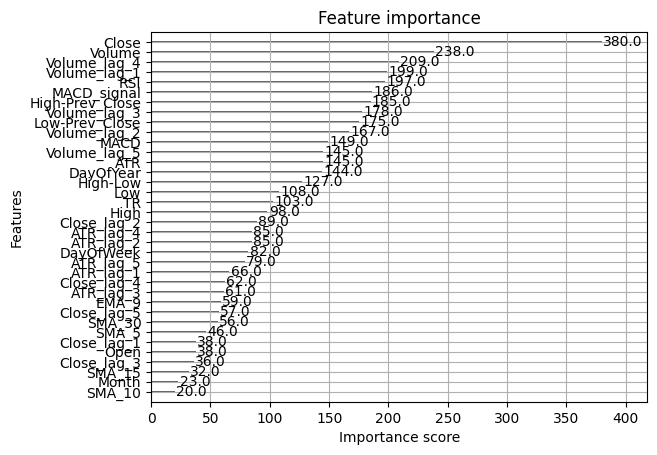

In [16]:
from xgboost import plot_importance
plot_importance(best_model.estimators_[0])
plt.show()

In [17]:
y_pred = best_model.predict(X_test)

In [18]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MAE = {mae}')
print(f'RMSE = {rmse}')

MAE = 38.71554183959961
RMSE = 43.13638606483365


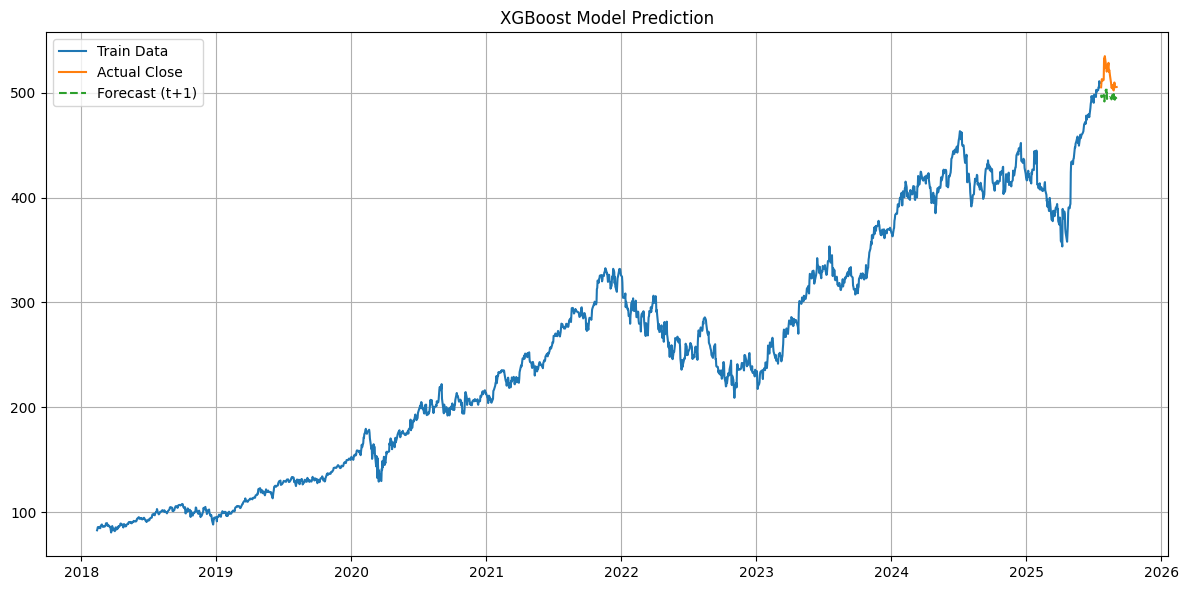

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(train_df["Date"], train_df["Close"], label="Train Data")
plt.plot(test_df["Date"].iloc[:len(y_pred)], y_test.iloc[:, 0], label="Actual Close")
plt.plot(test_df["Date"].iloc[:len(y_pred)], y_pred[:, 0], label="Forecast (t+1)", linestyle="dashed")
plt.legend()
plt.title("XGBoost Model Prediction")
plt.grid(True)
plt.tight_layout()
plt.show()